In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

In [2]:
df = pd.read_csv(r"..\..\scdb-case-timing-prediction\data\processed\scdb_processed_cropped_df2.csv")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9534 entries, 0 to 9533
Data columns (total 35 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   argument_month                     9534 non-null   int64  
 1   caseOrigin_group                   9534 non-null   object 
 2   caseSource_group                   9534 non-null   object 
 3   certReason_group                   9534 non-null   object 
 4   chief                              9534 non-null   object 
 5   complex_consolidated_disagreement  9509 non-null   float64
 6   days_from_term_start_to_argument   9534 non-null   int64  
 7   days_from_term_start_to_decision   9534 non-null   int64  
 8   decision_month                     9534 non-null   int64  
 9   decision_year                      9534 non-null   int64  
 10  docket_category                    9534 non-null   object 
 11  had_reargument                     9534 non-null   int64

Imputing remaining missing values and creating flags for such cases

In [4]:
# --- 1. Impute 'lcDisagreement' with Mode + Indicator Flag ---
LC_DISAGREE_COL = 'lcDisagreement'
if LC_DISAGREE_COL in df.columns and df[LC_DISAGREE_COL].isnull().any():
    print(f"\nHandling NaNs for '{LC_DISAGREE_COL}'...")
    df[LC_DISAGREE_COL + '_is_missing'] = df[LC_DISAGREE_COL].isnull().astype(int)
    print(f"- Created '{LC_DISAGREE_COL}_is_missing' indicator column.")

    mode_val = df[LC_DISAGREE_COL].mode()[0]
    df[LC_DISAGREE_COL] = df[LC_DISAGREE_COL].fillna(mode_val)
    print(f"- Imputed NaNs in '{LC_DISAGREE_COL}' with mode ({mode_val}).")
    print(f"  NaNs remaining in '{LC_DISAGREE_COL}': {df[LC_DISAGREE_COL].isnull().sum()}")

# --- 2. Impute 'threeJudgeFdc' with 0 + Indicator Flag ---
THREE_JUDGE_COL = 'threeJudgeFdc'
if THREE_JUDGE_COL in df.columns and df[THREE_JUDGE_COL].isnull().any():
    print(f"\nHandling NaNs for '{THREE_JUDGE_COL}'...")
    df[THREE_JUDGE_COL + '_is_missing'] = df[THREE_JUDGE_COL].isnull().astype(int)
    print(f"- Created '{THREE_JUDGE_COL}_is_missing' indicator column.")

    df[THREE_JUDGE_COL] = df[THREE_JUDGE_COL].fillna(0)
    print(f"- Imputed NaNs in '{THREE_JUDGE_COL}' with 0.")
    print(f"  NaNs remaining in '{THREE_JUDGE_COL}': {df[THREE_JUDGE_COL].isnull().sum()}")

# --- 3. Recalculate 'complex_consolidated_disagreement' ---
COMPLEX_COL = 'complex_consolidated_disagreement'
if COMPLEX_COL in df.columns:
    print(f"\nRecalculating '{COMPLEX_COL}' now that its components are imputed...")
    df[COMPLEX_COL] = df['num_dockets_in_case'] * df['lcDisagreement']
    print(f"- Recalculated '{COMPLEX_COL}'.")
    print(f"  NaNs remaining in '{COMPLEX_COL}': {df[COMPLEX_COL].isnull().sum()}")

# --- 4. Impute 'lcDispositionDirection' ---
LC_DISP_DIR_COL = 'lcDispositionDirection'
if LC_DISP_DIR_COL in df.columns and df[LC_DISP_DIR_COL].isnull().any():
    print(f"\nHandling NaNs for '{LC_DISP_DIR_COL}'...")
    df[LC_DISP_DIR_COL] = df[LC_DISP_DIR_COL].fillna(3)
    print("- Mapped NaNs to code 3 (Unspecifiable).")
    print(f"  NaNs remaining in '{LC_DISP_DIR_COL}': {df[LC_DISP_DIR_COL].isnull().sum()}")

print("\n--- Imputation of Low-Percentage NaNs Complete ---")


Handling NaNs for 'lcDisagreement'...
- Created 'lcDisagreement_is_missing' indicator column.
- Imputed NaNs in 'lcDisagreement' with mode (0.0).
  NaNs remaining in 'lcDisagreement': 0

Handling NaNs for 'threeJudgeFdc'...
- Created 'threeJudgeFdc_is_missing' indicator column.
- Imputed NaNs in 'threeJudgeFdc' with 0.
  NaNs remaining in 'threeJudgeFdc': 0

Recalculating 'complex_consolidated_disagreement' now that its components are imputed...
- Recalculated 'complex_consolidated_disagreement'.
  NaNs remaining in 'complex_consolidated_disagreement': 0

Handling NaNs for 'lcDispositionDirection'...
- Mapped NaNs to code 3 (Unspecifiable).
  NaNs remaining in 'lcDispositionDirection': 0

--- Imputation of Low-Percentage NaNs Complete ---


lcDispositionDirection since there already is a category for unspecified results, nans will be mapped as such.

In [5]:
df['lcDispositionDirection'] = df['lcDispositionDirection'].fillna(3).astype(int)

Encoding lcDispositionDirection values as conservative or liberal

In [6]:
df[['lcDispositionDirection_cons', 'lcDispositionDirection_lib']] = pd.get_dummies(df['lcDispositionDirection'], prefix='lcDispositionDirection')[['lcDispositionDirection_1', 'lcDispositionDirection_2']]
df = df.drop('lcDispositionDirection', axis=1)

In [7]:
df['caseOrigin_group'].value_counts()

caseOrigin_group
FedDistCt         6328
StateTrialCt      1766
FedCircCt          784
SpecialtyFedCt     299
Other/Unknown      203
StateHighCt         91
StateAppCt          59
TerritorialCt        4
Name: count, dtype: int64

We should combine the federal and state courts together to simplify things a little. The rest of the categories will be combined into "Other" category

In [8]:
df['caseOrigin_group'] = df['caseOrigin_group'].map({
   'FedDistCt': 'Federal',
   'FedCircCt': 'Federal',
   'SpecialtyFedCt': 'Federal',
   'StateTrialCt': 'State',
   'StateHighCt': 'State',
   'StateAppCt': 'State',
   'TerritorialCt': 'Other',
   'Other/Unknown': 'Other'
})
df['caseSource_group'] = df['caseSource_group'].map({
   'FedCircCt': 'Federal',
   'FedDistCt': 'Federal',
   'SpecialtyFedCt': 'Federal',
   'StateHighCt': 'State',
   'StateAppCt': 'State',
   'StateTrialCt': 'State',
   'TerritorialCt': 'Other',
   'Other/Unknown': 'Other'
})

print(df['caseSource_group'].value_counts(),'\n',df['caseOrigin_group'].value_counts())

caseSource_group
Federal    7491
State      1920
Other       123
Name: count, dtype: int64 
 caseOrigin_group
Federal    7411
State      1916
Other       207
Name: count, dtype: int64


In [9]:
print(df['certReason_group'].value_counts())

certReason_group
No Reason Given            3078
Important Question         2435
Court Conflict             2042
Not Applicable / Denied    1776
Other Reason                 97
Confusion/Uncertainty        67
Unknown/Missing              39
Name: count, dtype: int64


certReason_group we will combine into higher-level concept groups:
- Substantive Reasons (the court identifies a legal reason) (Important Question + Court Conflict + Confusion/Uncertainty)
- Procedural/Administrative (the case lacks reasoning or is procedural) (No Reason Given + Not Applicable/Denied)

and the rest will go into 
- Other (Other Reason + Unknown/Missing)

In [10]:
df['certReason_group'] = df['certReason_group'].map({
   'Important Question': 'Substantive Reasons',
   'Court Conflict': 'Substantive Reasons',
   'Confusion/Uncertainty': 'Substantive Reasons',
   'No Reason Given': 'Procedural/Administrative',
   'Not Applicable / Denied': 'Procedural/Administrative',
   'Other Reason': 'Other',
   'Unknown/Missing': 'Other'
})

print(df['certReason_group'].value_counts())

certReason_group
Procedural/Administrative    4854
Substantive Reasons          4544
Other                         136
Name: count, dtype: int64


In [11]:
print(df['docket_category'].value_counts())

docket_category
Merits/Other     9409
Original          103
Miscellaneous      22
Name: count, dtype: int64


this variable is here to tell us if the case was a "special" docket. Thus, in order to simplify this and avoid having very rare categories, we will combine all "special" cases together.

In [12]:
df['docket_category'] = df['docket_category'].map({
   'Merits/Other': 'Merits/Other',
   'Original': 'Special Jurisdiction',
   'Miscellaneous': 'Special Jurisdiction'
})

print(df['docket_category'].value_counts())

docket_category
Merits/Other            9409
Special Jurisdiction     125
Name: count, dtype: int64


In [13]:
print(df['issueArea_name'].value_counts())

issueArea_name
Economic Activity       2152
Criminal Procedure      1895
Civil Rights            1498
Judicial Power          1215
First Amendment          740
Federalism               444
Unions                   428
Due Process              392
Federal Taxation         355
Privacy                  132
Attorneys                 94
Interstate Relations      74
Unknown/Missing Code      68
Miscellaneous             42
Private Action             5
Name: count, dtype: int64


in order to keep the amount of categories to a minimum, but also to preserve the most popular issues without grouping them, we will combine the least popular ones into constitutional and non-consitutional (constitional cases may require longer discussions and more insighttful opinions, which may impact decision time)

In [14]:
df['issueArea_name'] = df['issueArea_name'].map({
   'Economic Activity': 'Economic Activity',
   'Criminal Procedure': 'Criminal Procedure',
   'Civil Rights': 'Civil Rights',
   'Judicial Power': 'Judicial Power',
   'First Amendment': 'First Amendment',
   'Federalism': 'Other Constitutional',
   'Due Process': 'Other Constitutional',
   'Privacy': 'Other Constitutional',
   'Unions': 'Other Non-Constitutional',
   'Federal Taxation': 'Other Non-Constitutional',
   'Attorneys': 'Other Non-Constitutional',
   'Interstate Relations': 'Other Non-Constitutional',
   'Miscellaneous': 'Other Non-Constitutional',
   'Private Action': 'Other Non-Constitutional'
})

print(df['issueArea_name'].value_counts())

issueArea_name
Economic Activity           2152
Criminal Procedure          1895
Civil Rights                1498
Judicial Power              1215
Other Non-Constitutional     998
Other Constitutional         968
First Amendment              740
Name: count, dtype: int64


Dropping issue_x_jurisdiction as it is covered by other variables and too granular for modelling

In [15]:
print(df['issue_x_jurisdiction'].value_counts())
df = df.drop('issue_x_jurisdiction', axis=1)

issue_x_jurisdiction
Criminal Procedure_via_Certiorari          1785
Economic Activity_via_Certiorari           1691
Civil Rights_via_Certiorari                1090
Judicial Power_via_Certiorari              1010
First Amendment_via_Certiorari              493
Economic Activity_via_Appeal                441
Unions_via_Certiorari                       411
Civil Rights_via_Appeal                     394
Federal Taxation_via_Certiorari             347
Federalism_via_Certiorari                   331
Due Process_via_Certiorari                  300
First Amendment_via_Appeal                  247
Judicial Power_via_Appeal                   184
Privacy_via_Certiorari                      109
Criminal Procedure_via_Appeal               105
Due Process_via_Appeal                       92
Attorneys_via_Certiorari                     87
Federalism_via_Appeal                        82
Unknown/Missing Code_via_Certiorari          59
Interstate Relations_via_Original            56
Miscellaneous_via_C

In [16]:
print(df['jurisdiction_group'].value_counts())

jurisdiction_group
Certiorari          7768
Appeal              1615
Original             112
Writ                  20
Other Procedural      11
Certification          6
Unknown/Missing        2
Name: count, dtype: int64


we will divide the cases into ones that:
- have discretionary jurisdiction (court doesn't have to review them, 4 judges must vote in order to proceed)
- have mandatory jurisdiction (court has to review them, no matter what)
- other

In [17]:
df['jurisdiction_group'] = df['jurisdiction_group'].map({
   'Certiorari': 'Discretionary',
   'Appeal': 'Mandatory',
   'Original': 'Mandatory',
   'Writ': 'Other',
   'Other Procedural': 'Other',
   'Certification': 'Other',
   'Unknown/Missing': 'Other'
})

print(df['jurisdiction_group'].value_counts())


jurisdiction_group
Discretionary    7768
Mandatory        1727
Other              39
Name: count, dtype: int64


In [18]:
print(df['lawType_group'].value_counts())

lawType_group
Fed Statute               3219
Const Amendment           2440
Infrequent Fed Statute    1804
Unknown/Missing            890
Constitution               550
Other                      314
Court Rules                266
No Legal Provision          42
State/Local Law              9
Name: count, dtype: int64


lawType_group will be divided into statuatory and constitutional categories. The rest will be put into other/unknown category, due to a relatively high percentage of missing cases.

In [19]:
df['lawType_group'] = df['lawType_group'].map({
   'Const Amendment': 'Constitutional',
   'Constitution': 'Constitutional',
   'Fed Statute': 'Statutory',
   'Infrequent Fed Statute': 'Statutory',
   'Court Rules': 'Other/Unknown',
   'State/Local Law': 'Other/Unknown',
   'Other': 'Other/Unknown',
   'No Legal Provision': 'Other/Unknown',
   'Unknown/Missing': 'Other/Unknown'
})

print(df['lawType_group'].value_counts())

lawType_group
Statutory         5023
Constitutional    2990
Other/Unknown     1521
Name: count, dtype: int64


In [20]:
print(df['lcDisposition_group'].value_counts())

lcDisposition_group
Affirmed            4624
Reversed            2639
Unknown/Missing     1152
Procedural           653
Vacated/Remanded     466
Name: count, dtype: int64


we divide the cases into ones that were upheld by the supreme court (affirmed), or when the lower courts rulings were changed or reversed in any way (reversed/modified). Other cases where the outcome is unknown or doesnt apply (like in procedural cases)

In [21]:
df['lcDisposition_group'] = df['lcDisposition_group'].map({
   'Affirmed': 'Affirmed',
   'Reversed': 'Reversed/Modified',
   'Vacated/Remanded': 'Reversed/Modified',
   'Procedural': 'Other/Unknown',
   'Unknown/Missing': 'Other/Unknown'
})

print(df['lcDisposition_group'].value_counts())

lcDisposition_group
Affirmed             4624
Reversed/Modified    3105
Other/Unknown        1805
Name: count, dtype: int64


Dropping disagree_direction as it is also covered by other variables

In [22]:
print(df['lc_disagree_direction'].value_counts())
df = df.drop('lc_disagree_direction', axis=1)

lc_disagree_direction
LC_Agree_Conservative       3965
LC_Agree_Liberal            3134
LC_Disagree_Conservative    1094
LC_Disagree_Liberal         1053
LC_Unspec/Other              288
Name: count, dtype: int64


In [23]:
print(df['petitioner_group'].value_counts())

petitioner_group
Other/Unknown       4309
Individual          1007
US Govt              918
US Agency            906
State Govt           823
Business             755
Local Govt           277
Employee             218
Union                214
Indian                63
US Govt Official      44
Name: count, dtype: int64


we will simply split all petitioners into government and private entities. Same with respondents.

In [24]:
df['petitioner_group'] = df['petitioner_group'].map({
   'US Govt': 'Government',
   'US Agency': 'Government',
   'State Govt': 'Government',
   'Local Govt': 'Government',
   'US Govt Official': 'Government',
   'Individual': 'Private Entities',
   'Business': 'Private Entities',
   'Employee': 'Private Entities',
   'Union': 'Private Entities',
   'Indian': 'Private Entities',
   'Other/Unknown': 'Other/Unknown'
})
df['respondent_group'] = df['respondent_group'].map({
   'US Govt': 'Government',
   'US Agency': 'Government',
   'State Govt': 'Government',
   'Local Govt': 'Government',
   'US Govt Official': 'Government',
   'Individual': 'Private Entities',
   'Business': 'Private Entities',
   'Employee': 'Private Entities',
   'Union': 'Private Entities',
   'Indian': 'Private Entities',
   'Other/Unknown': 'Other/Unknown'
})

print(df['petitioner_group'].value_counts(),'\n',df['respondent_group'].value_counts())

petitioner_group
Other/Unknown       4309
Government          2968
Private Entities    2257
Name: count, dtype: int64 
 respondent_group
Other/Unknown       4042
Government          3511
Private Entities    1981
Name: count, dtype: int64


One more variable deleted because of tis granularity and limited usability

In [25]:
print(df['threeJudge_x_issue'].value_counts())
df = df.drop('threeJudge_x_issue', axis=1)

threeJudge_x_issue
Economic Activity_3Judge_0.0       1998
Criminal Procedure_3Judge_0.0      1883
Civil Rights_3Judge_0.0            1250
Judicial Power_3Judge_0.0          1086
First Amendment_3Judge_0.0          648
Federalism_3Judge_0.0               433
Unions_3Judge_0.0                   425
Due Process_3Judge_0.0              360
Federal Taxation_3Judge_0.0         355
Civil Rights_3Judge_1.0             247
Economic Activity_3Judge_1.0        153
Judicial Power_3Judge_1.0           128
Privacy_3Judge_0.0                  121
Attorneys_3Judge_0.0                 94
First Amendment_3Judge_1.0           91
Interstate Relations_3Judge_0.0      72
Unknown/Missing Code_3Judge_0.0      61
Miscellaneous_3Judge_0.0             39
Due Process_3Judge_1.0               30
Privacy_3Judge_1.0                   11
Criminal Procedure_3Judge_1.0        10
Federalism_3Judge_1.0                 9
Unknown/Missing Code_3Judge_nan       5
Private Action_3Judge_0.0             5
Unions_3Judge_1.0    

Saving the dataset with combined variables

In [26]:
df.to_csv(r"..\..\scdb-case-timing-prediction\data\processed\scdb_processed_final.csv", index=False)

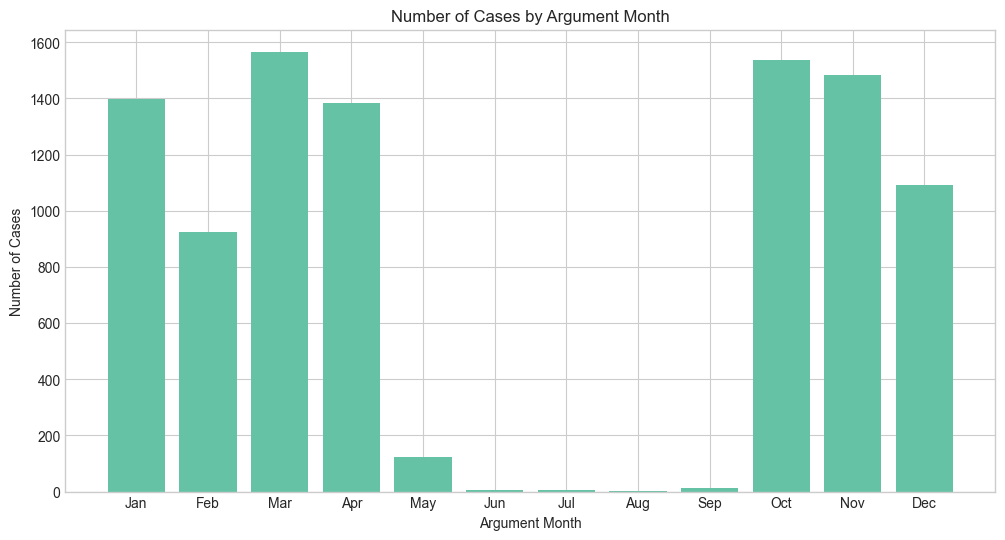

In [27]:
plt.figure(figsize=(12, 6))
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
argument_counts = df['argument_month'].value_counts().sort_index()

plt.bar(range(1, len(argument_counts)+1), argument_counts.values)
plt.xticks(range(1, len(argument_counts)+1), month_names[:len(argument_counts)])
plt.title('Number of Cases by Argument Month')
plt.xlabel('Argument Month')
plt.ylabel('Number of Cases')
plt.show()

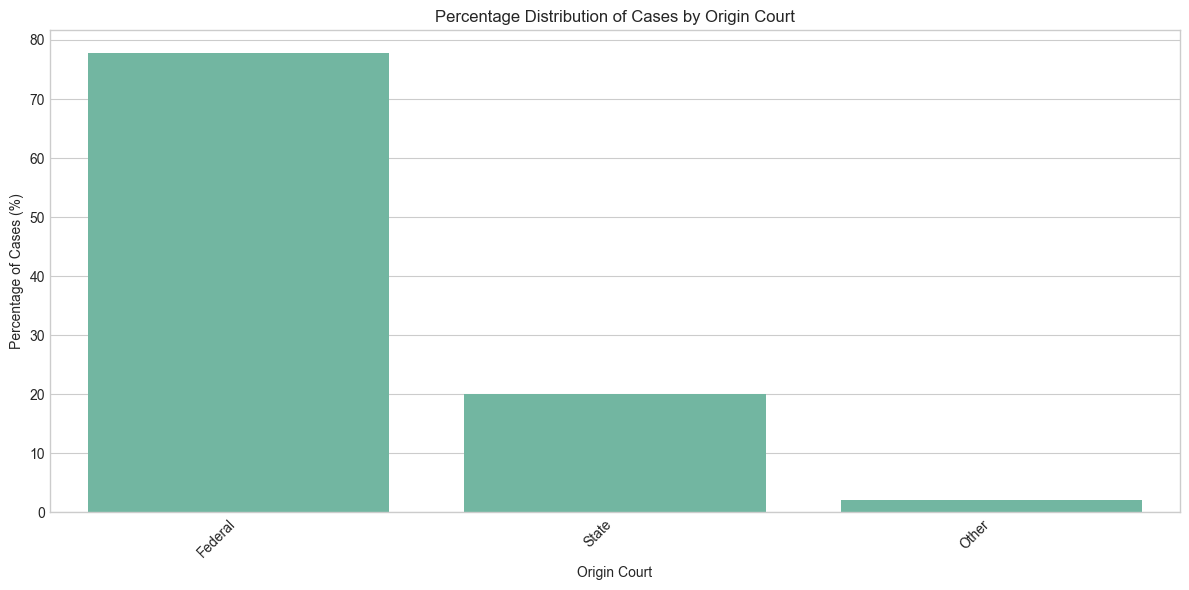

In [28]:
plt.figure(figsize=(12, 6))
origin_counts = df['caseOrigin_group'].value_counts(normalize=True) * 100
sns.barplot(x=origin_counts.index, y=origin_counts.values)
plt.title('Percentage Distribution of Cases by Origin Court')
plt.xlabel('Origin Court')
plt.ylabel('Percentage of Cases (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

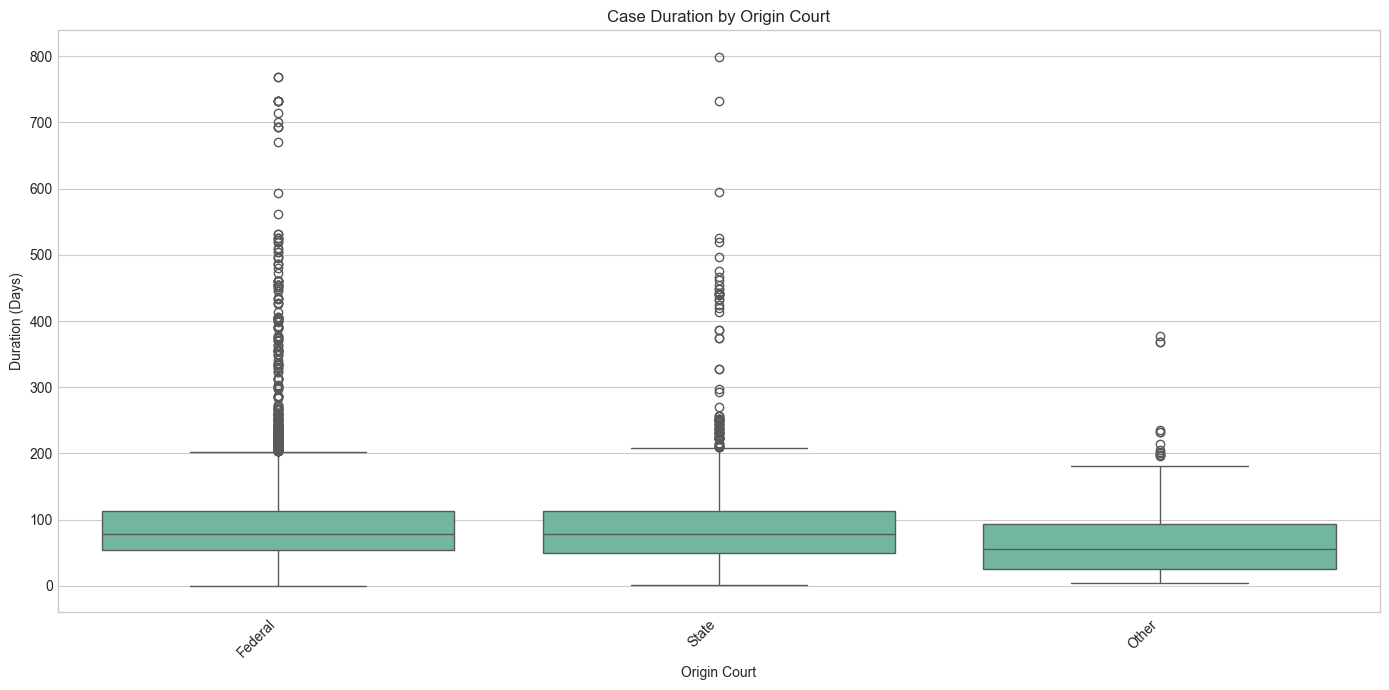

In [29]:
plt.figure(figsize=(14, 7))
sns.boxplot(x='caseOrigin_group', y='duration_days', data=df)
plt.title('Case Duration by Origin Court')
plt.xlabel('Origin Court')
plt.ylabel('Duration (Days)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

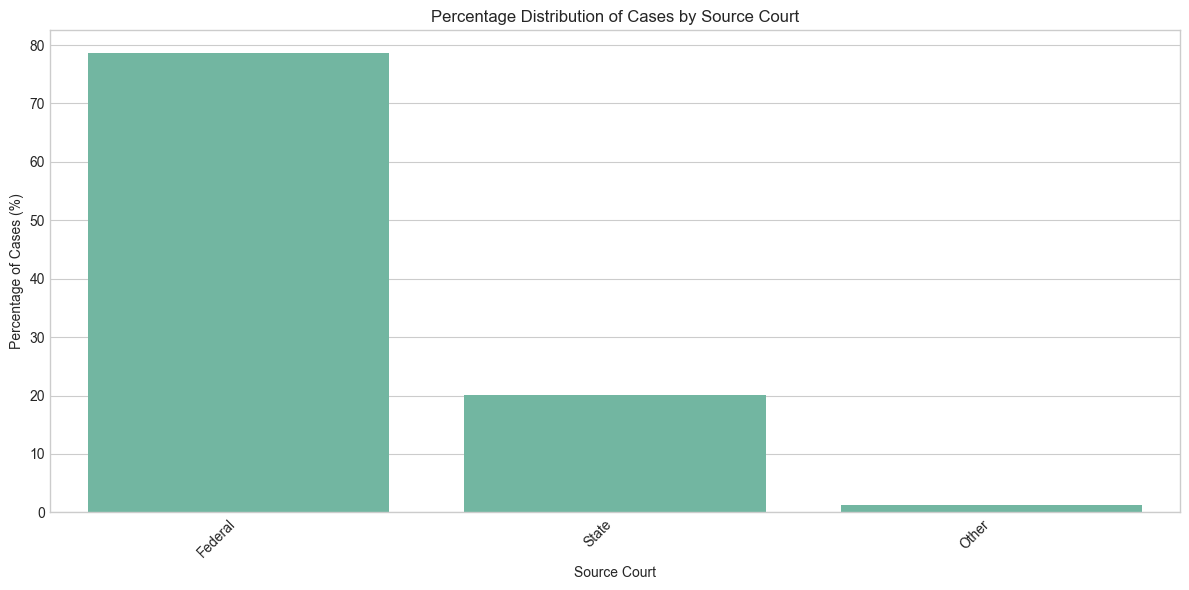

In [30]:
plt.figure(figsize=(12, 6))
source_counts = df['caseSource_group'].value_counts(normalize=True) * 100
sns.barplot(x=source_counts.index, y=source_counts.values)
plt.title('Percentage Distribution of Cases by Source Court')
plt.xlabel('Source Court')
plt.ylabel('Percentage of Cases (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

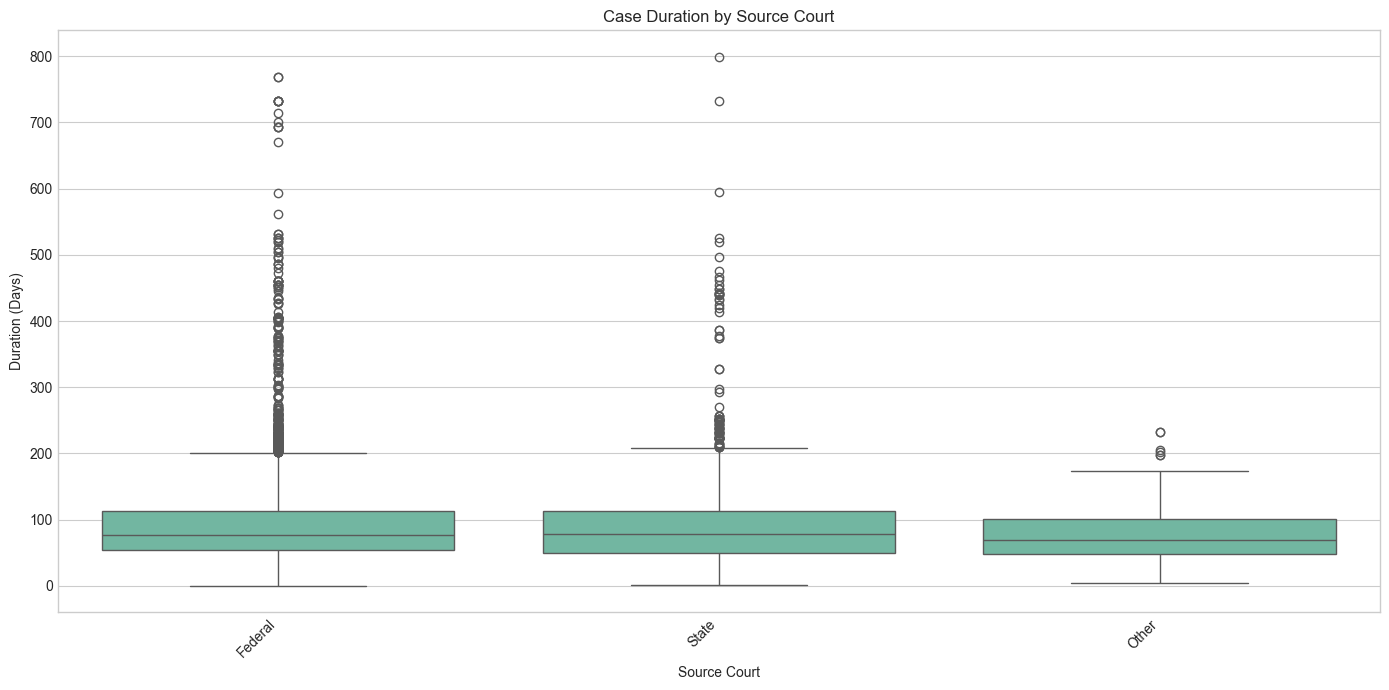

In [31]:
plt.figure(figsize=(14, 7))
sns.boxplot(x='caseSource_group', y='duration_days', data=df)
plt.title('Case Duration by Source Court')
plt.xlabel('Source Court')
plt.ylabel('Duration (Days)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

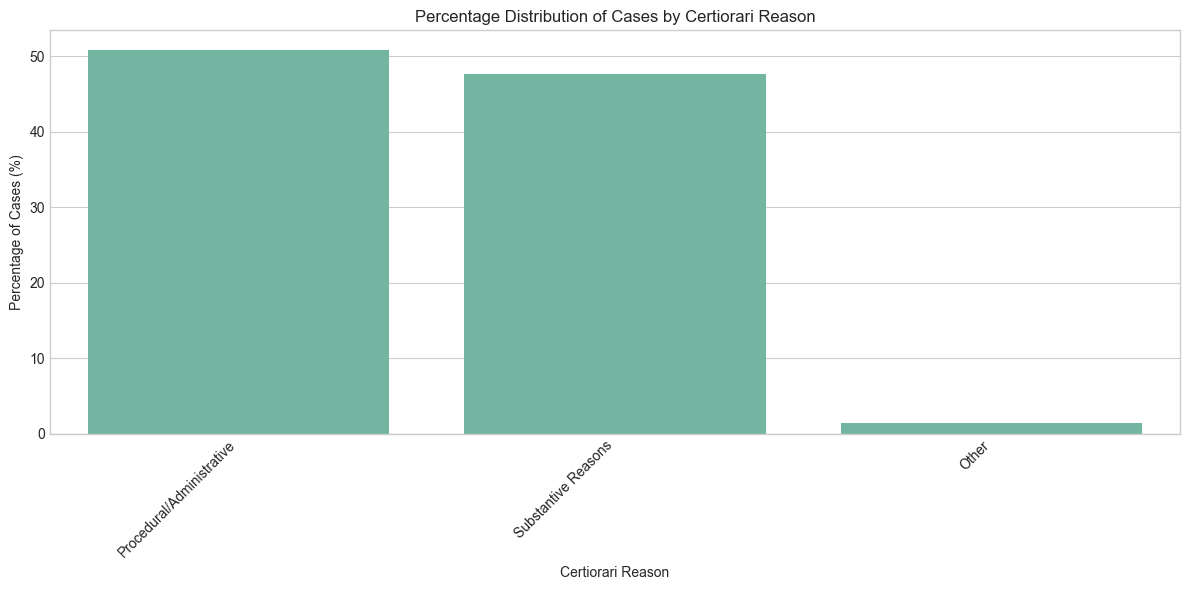

In [32]:
plt.figure(figsize=(12, 6))
cert_counts = df['certReason_group'].value_counts(normalize=True) * 100
sns.barplot(x=cert_counts.index, y=cert_counts.values)
plt.title('Percentage Distribution of Cases by Certiorari Reason')
plt.xlabel('Certiorari Reason')
plt.ylabel('Percentage of Cases (%)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


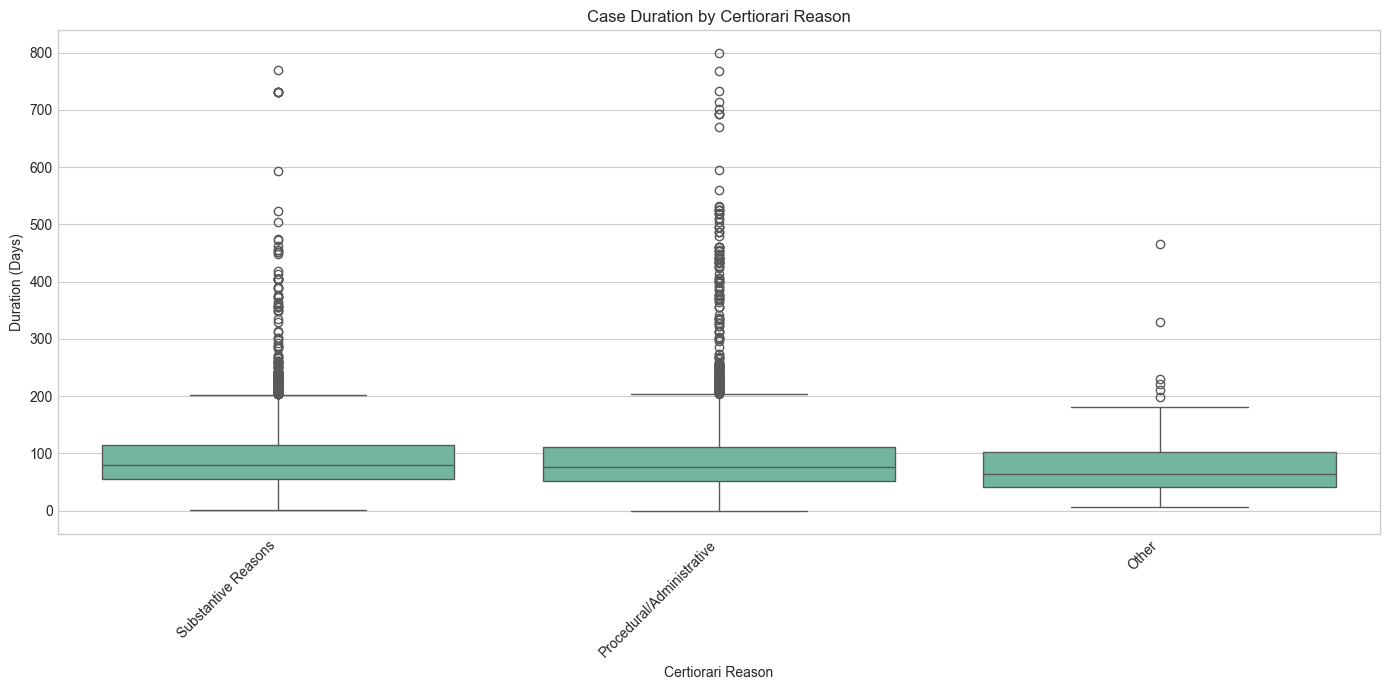

In [33]:
plt.figure(figsize=(14, 7))
sns.boxplot(x='certReason_group', y='duration_days', data=df)
plt.title('Case Duration by Certiorari Reason')
plt.xlabel('Certiorari Reason')
plt.ylabel('Duration (Days)')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

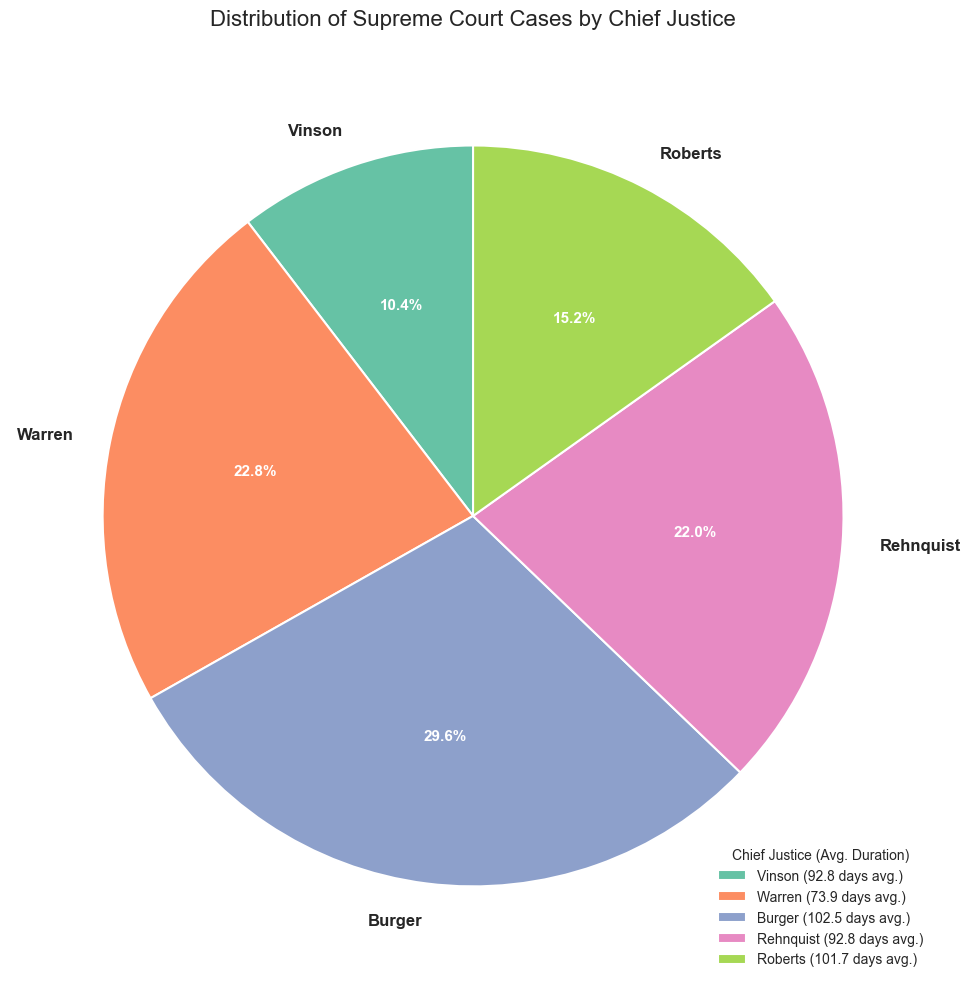

In [34]:
chief_order = ['Vinson', 'Warren', 'Burger', 'Rehnquist', 'Roberts']

chief_counts = df['chief'].value_counts(normalize=True) * 100
chief_counts = chief_counts.reindex(chief_order) 

colors = sns.color_palette("Set2", len(chief_order))

plt.figure(figsize=(10, 10))
patches, texts, autotexts = plt.pie(
    chief_counts, 
    labels=chief_counts.index, 
    colors=colors,
    autopct='%1.1f%%', 
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

for text in texts:
    text.set_fontsize(12)
    text.set_fontweight('bold')
for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_fontweight('bold')
    autotext.set_color('white')

plt.title('Distribution of Supreme Court Cases by Chief Justice', fontsize=16, pad=20)

means = df.groupby('chief')['duration_days'].mean()
means = means.reindex(chief_order)
legend_labels = [f"{chief} ({means[chief]:.1f} days avg.)" for chief in chief_order]
plt.legend(legend_labels, title="Chief Justice (Avg. Duration)", 
           loc="lower right")

plt.tight_layout()
plt.show()

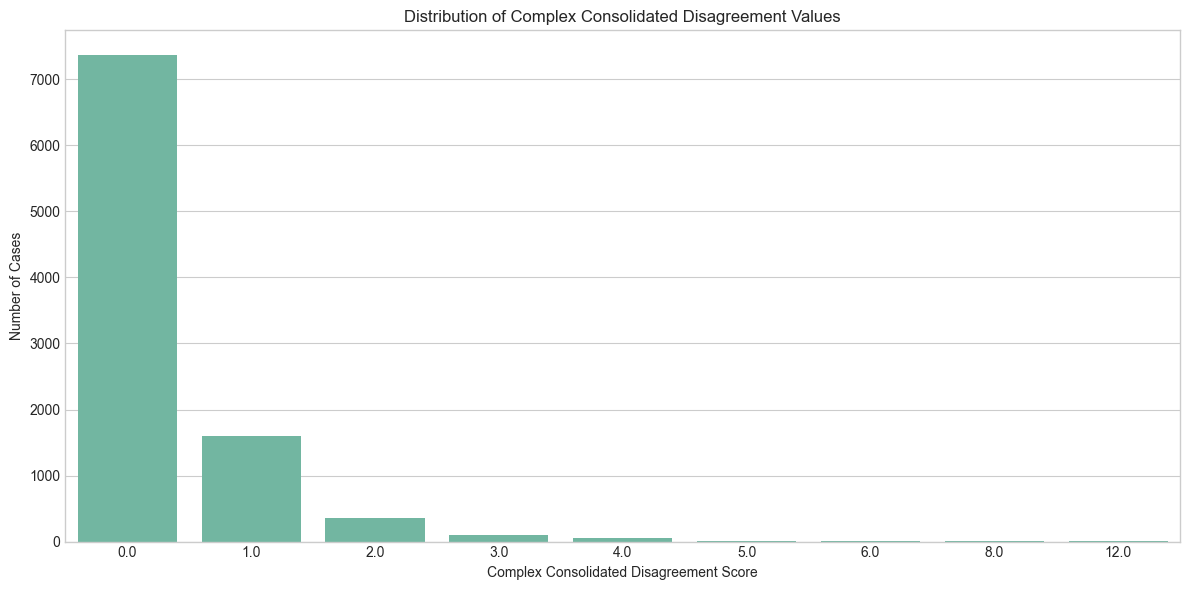

In [35]:
plt.figure(figsize=(12, 6))
value_counts = df['complex_consolidated_disagreement'].value_counts().sort_index()
sns.barplot(x=value_counts.index.astype(str), y=value_counts.values)
plt.title('Distribution of Complex Consolidated Disagreement Values')
plt.xlabel('Complex Consolidated Disagreement Score')
plt.ylabel('Number of Cases')
plt.tight_layout()
plt.show()

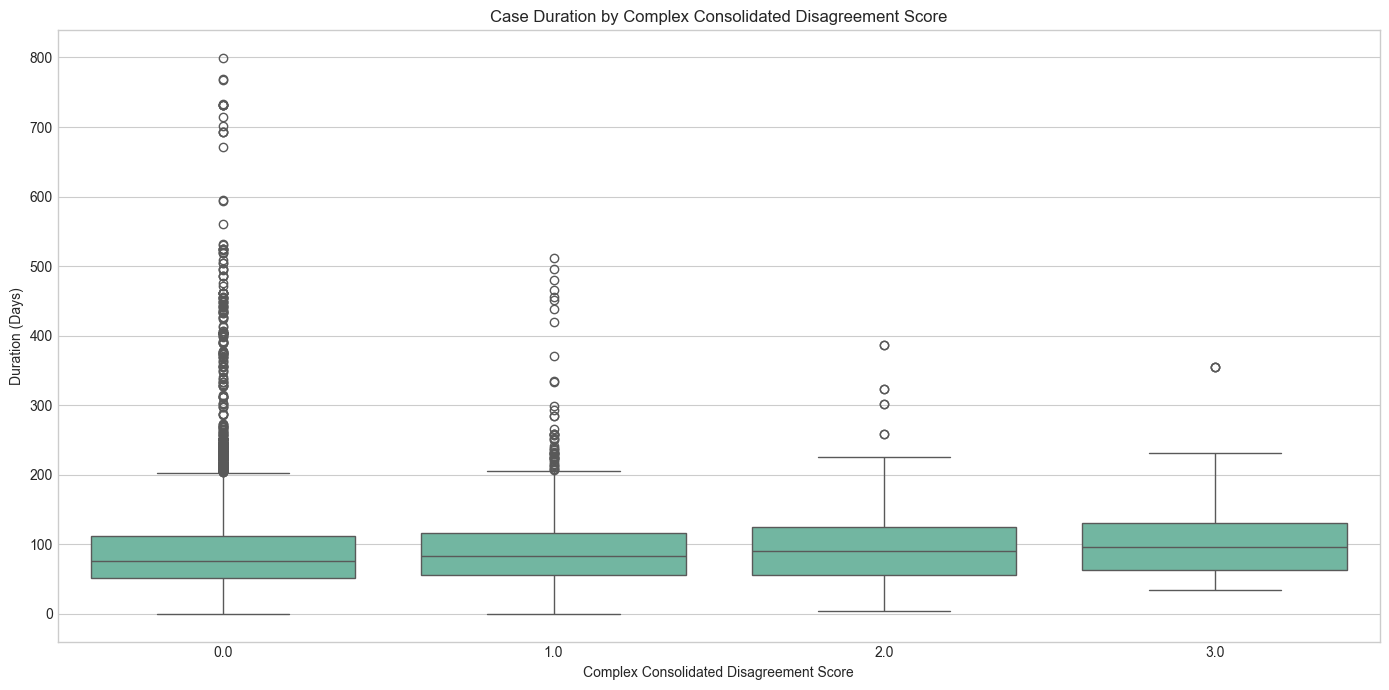

In [36]:
plt.figure(figsize=(14, 7))
common_values = df['complex_consolidated_disagreement'].value_counts()
common_values = common_values[common_values > 50]
filtered_df = df[df['complex_consolidated_disagreement'].isin(common_values.index)]

sns.boxplot(x='complex_consolidated_disagreement', y='duration_days', data=filtered_df)
plt.title('Case Duration by Complex Consolidated Disagreement Score')
plt.xlabel('Complex Consolidated Disagreement Score')
plt.ylabel('Duration (Days)')
plt.tight_layout()
plt.show()

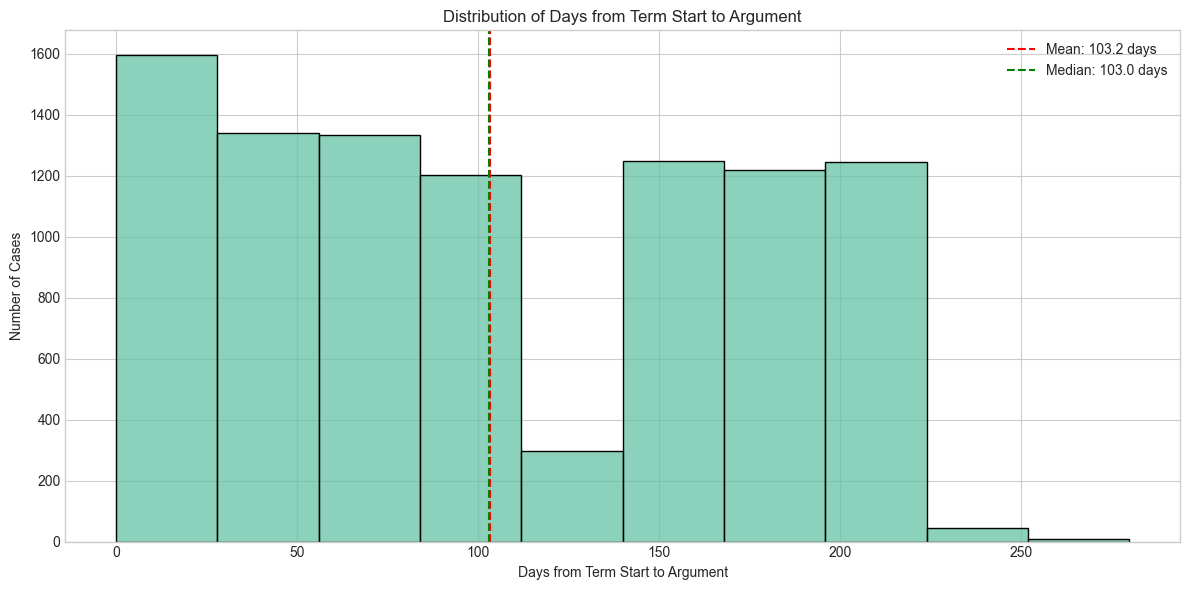

In [37]:
plt.figure(figsize=(12, 6))
sns.histplot(df['days_from_term_start_to_argument'], bins=10, kde=False)
plt.title('Distribution of Days from Term Start to Argument')
plt.xlabel('Days from Term Start to Argument')
plt.ylabel('Number of Cases')
plt.axvline(df['days_from_term_start_to_argument'].mean(), color='red', linestyle='--', 
            label=f'Mean: {df["days_from_term_start_to_argument"].mean():.1f} days')
plt.axvline(df['days_from_term_start_to_argument'].median(), color='green', linestyle='--', 
            label=f'Median: {df["days_from_term_start_to_argument"].median():.1f} days')
plt.legend()
plt.tight_layout()
plt.show()

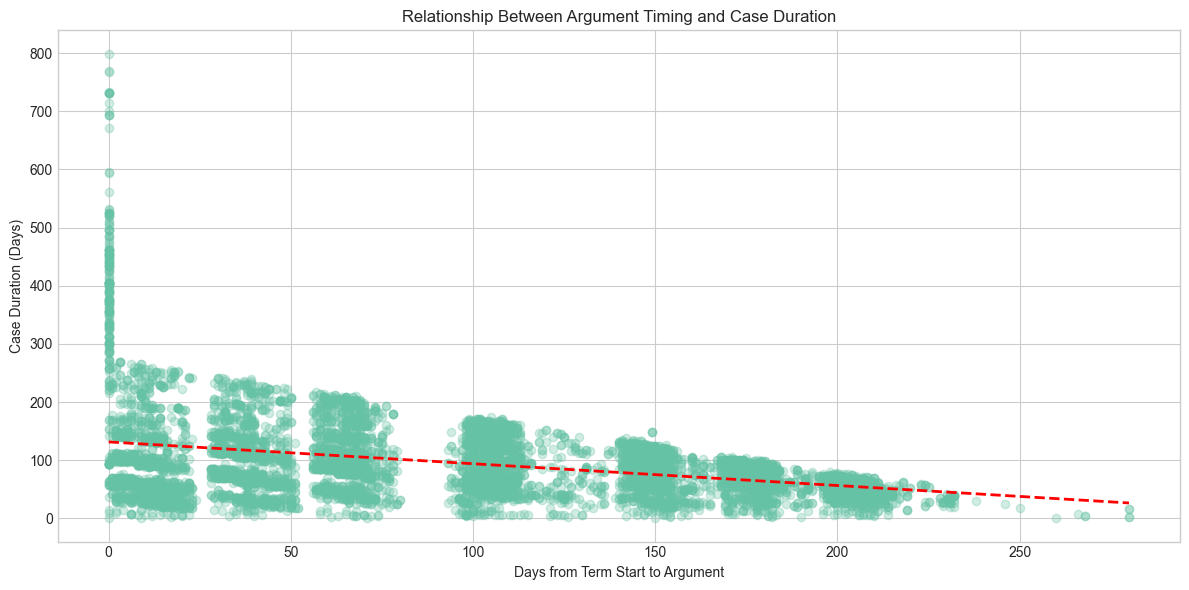

In [38]:
plt.figure(figsize=(12, 6))
plt.scatter(df['days_from_term_start_to_argument'], df['duration_days'], alpha=0.3)
plt.title('Relationship Between Argument Timing and Case Duration')
plt.xlabel('Days from Term Start to Argument')
plt.ylabel('Case Duration (Days)')

z = np.polyfit(df['days_from_term_start_to_argument'], df['duration_days'], 1)
p = np.poly1d(z)
plt.plot(sorted(df['days_from_term_start_to_argument'].unique()), 
         p(sorted(df['days_from_term_start_to_argument'].unique())), 
         "r--", linewidth=2)

plt.tight_layout()
plt.show()

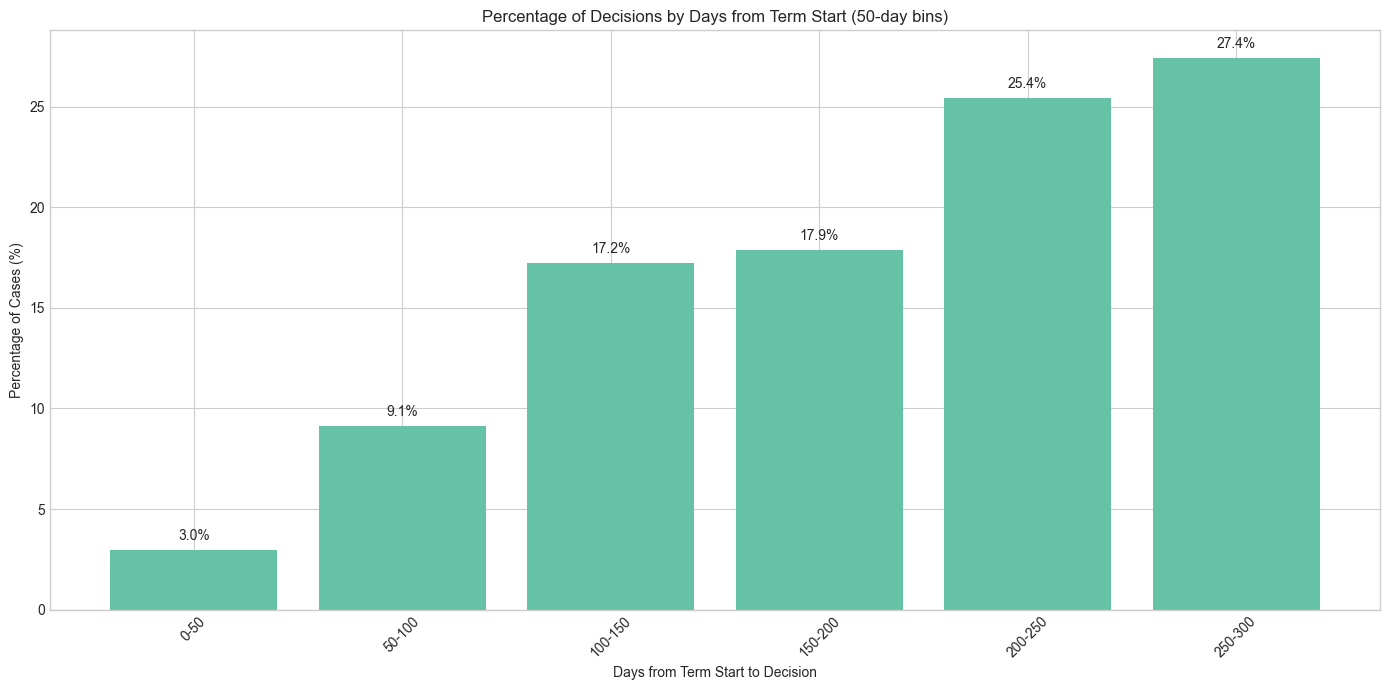

In [39]:
df['decision_timing_bin'] = pd.cut(df['days_from_term_start_to_decision'], 
                                  bins=range(0, 301, 50), 
                                  labels=[f"{i}-{i+50}" for i in range(0, 300, 50)])

binned_data = df.dropna(subset=['decision_timing_bin'])

bin_sizes = binned_data['decision_timing_bin'].value_counts().sort_index()
total_cases = len(binned_data)
bin_percentages = (bin_sizes / total_cases) * 100

plt.figure(figsize=(14, 7))
plt.bar(range(len(bin_percentages)), bin_percentages.values)
plt.xticks(range(len(bin_percentages)), bin_percentages.index, rotation=45)
plt.title('Percentage of Decisions by Days from Term Start (50-day bins)')
plt.xlabel('Days from Term Start to Decision')
plt.ylabel('Percentage of Cases (%)')
for i, pct in enumerate(bin_percentages):
    plt.text(i, pct + 0.5, f'{pct:.1f}%', ha='center')
plt.tight_layout()
plt.show()

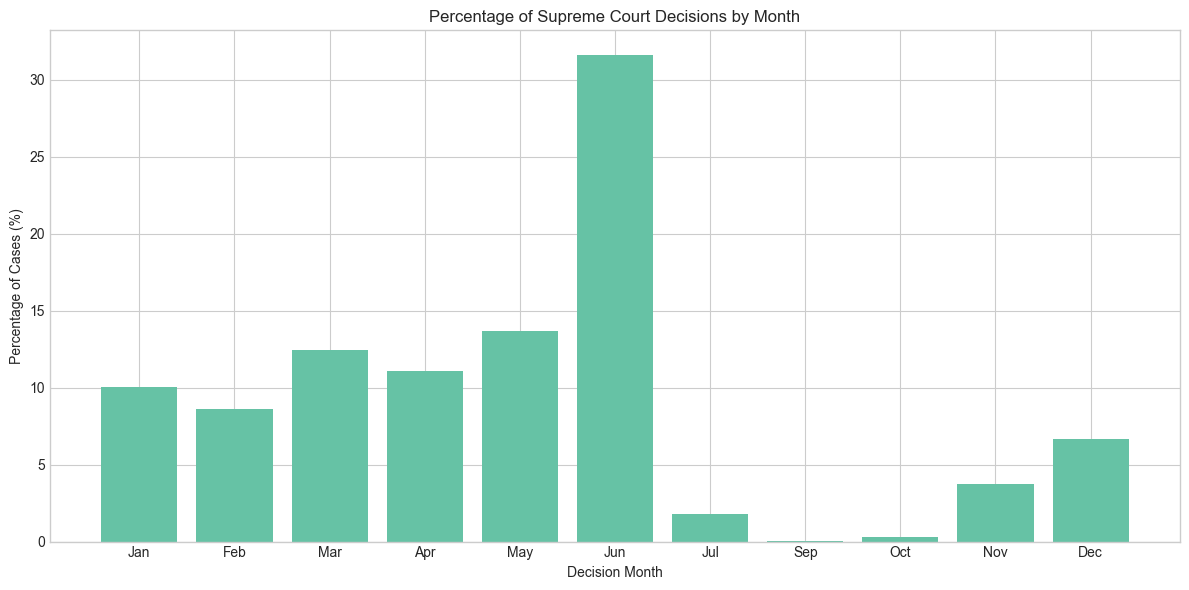

In [40]:
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
decision_month_counts = df['decision_month'].value_counts().sort_index()
month_indices = decision_month_counts.index
month_labels = [month_names[i-1] for i in month_indices]

total_cases = len(df)
month_percentages = (decision_month_counts / total_cases) * 100

plt.figure(figsize=(12, 6))
bars = plt.bar(month_labels, month_percentages)
plt.title('Percentage of Supreme Court Decisions by Month')
plt.xlabel('Decision Month')
plt.ylabel('Percentage of Cases (%)')
plt.tight_layout()
plt.show()

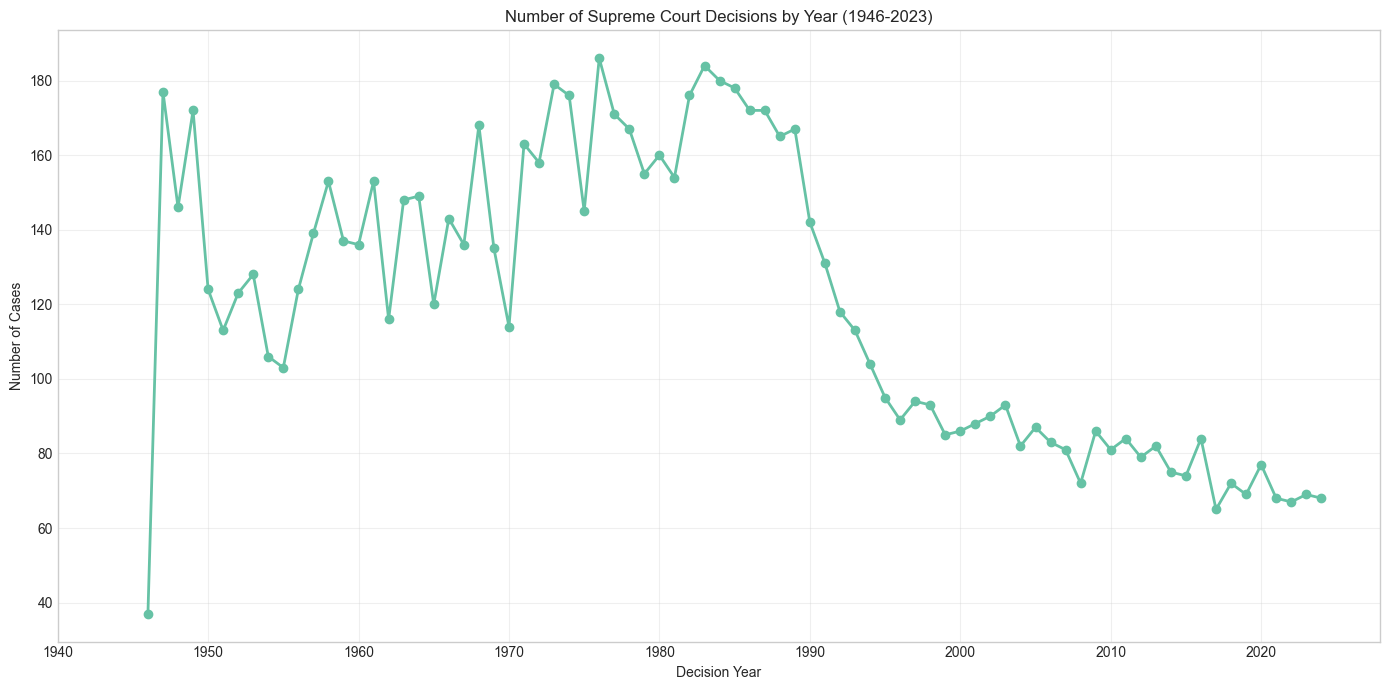

In [41]:
plt.figure(figsize=(14, 7))
year_counts = df['decision_year'].value_counts().sort_index()
plt.plot(year_counts.index, year_counts.values, marker='o', linewidth=2)
plt.title('Number of Supreme Court Decisions by Year (1946-2023)')
plt.xlabel('Decision Year')
plt.ylabel('Number of Cases')
plt.grid(True, alpha=0.3)
plt.xticks(range(1940, 2030, 10))
plt.tight_layout()
plt.show()

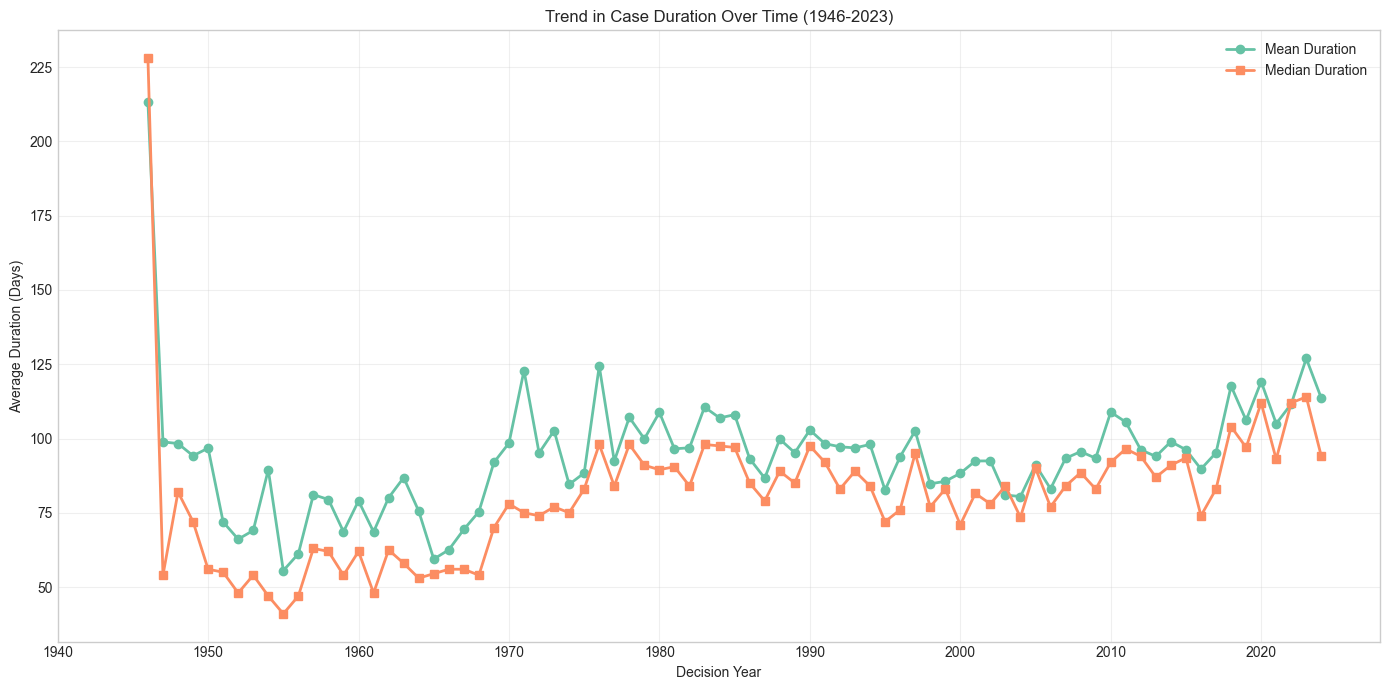

In [42]:
yearly_mean = df.groupby('decision_year')['duration_days'].mean()
yearly_median = df.groupby('decision_year')['duration_days'].median()

plt.figure(figsize=(14, 7))
plt.plot(yearly_mean.index, yearly_mean.values, marker='o', linewidth=2, label='Mean Duration')
plt.plot(yearly_median.index, yearly_median.values, marker='s', linewidth=2, label='Median Duration')
plt.title('Trend in Case Duration Over Time (1946-2023)')
plt.xlabel('Decision Year')
plt.ylabel('Average Duration (Days)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(range(1940, 2030, 10)) 
plt.tight_layout()
plt.show()

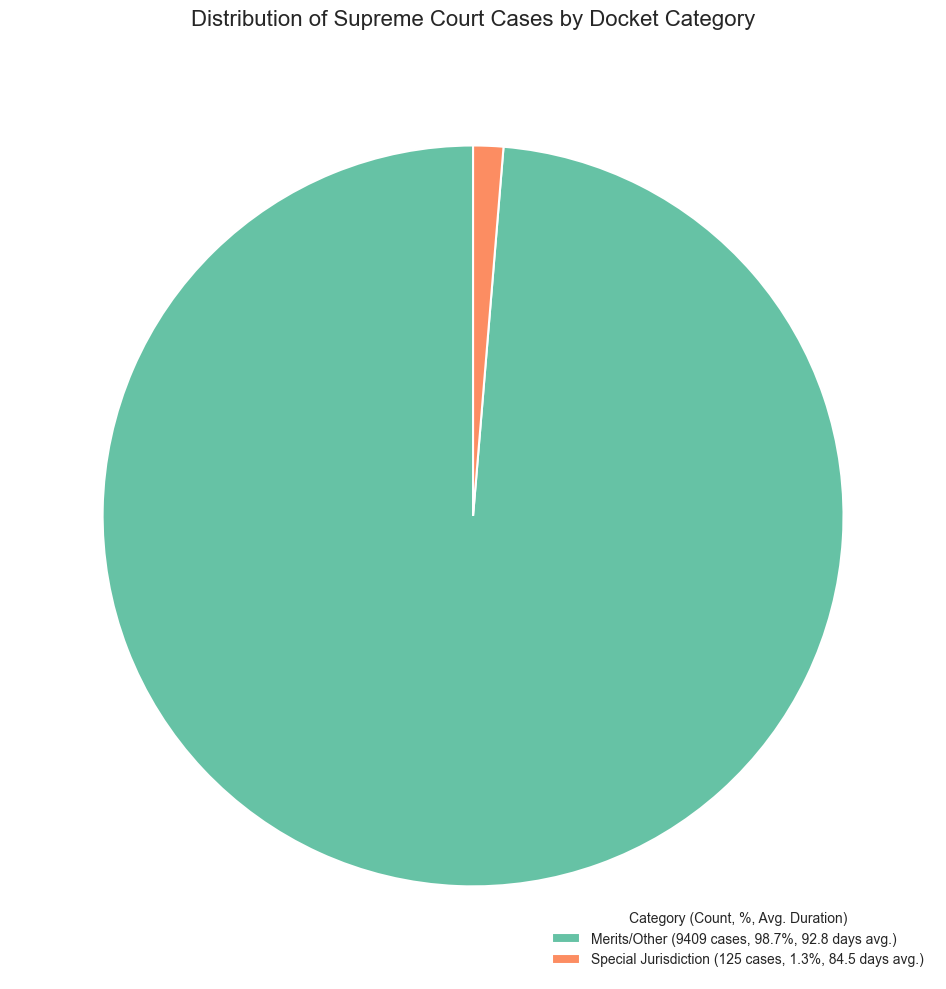

In [43]:
docket_counts = df['docket_category'].value_counts()
total_cases = len(df)
docket_percentages = (docket_counts / total_cases) * 100

plt.figure(figsize=(10, 10))
colors = sns.color_palette("Set2", len(docket_counts))
wedges, texts = plt.pie(
    docket_counts, 
    labels=None,
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

plt.title('Distribution of Supreme Court Cases by Docket Category', fontsize=16, pad=20)

mean_durations = df.groupby('docket_category')['duration_days'].mean()
legend_labels = [f"{cat} ({count} cases, {percentage:.1f}%, {mean_durations[cat]:.1f} days avg.)" 
                for cat, count, percentage in zip(docket_counts.index, docket_counts.values, docket_percentages)]
plt.legend(legend_labels, title="Category (Count, %, Avg. Duration)", 
          loc="lower right")

plt.tight_layout()
plt.show()

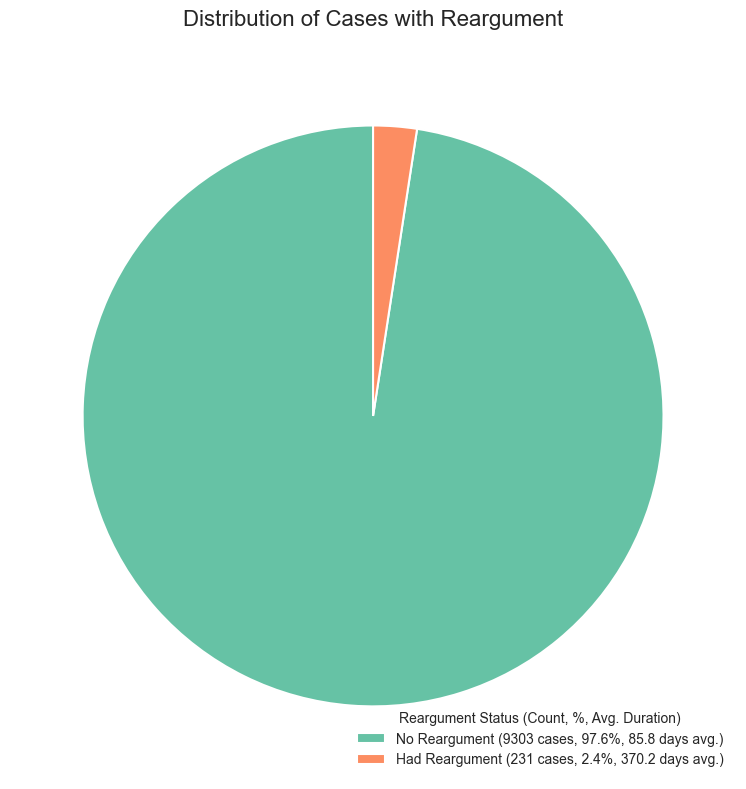

In [44]:
rearg_counts = df['had_reargument'].value_counts().sort_index()
total_cases = len(df)
rearg_percentages = (rearg_counts / total_cases) * 100

plt.figure(figsize=(10, 8))
colors = sns.color_palette("Set2", len(rearg_counts))
plt.pie(
    rearg_counts, 
    labels=None, 
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

plt.title('Distribution of Cases with Reargument', fontsize=16, pad=20)

mean_durations = df.groupby('had_reargument')['duration_days'].mean()
rearg_labels = {0: "No Reargument", 1: "Had Reargument"}
legend_labels = [f"{rearg_labels[val]} ({count} cases, {percentage:.1f}%, {mean_durations[val]:.1f} days avg.)" 
                for val, count, percentage in zip(rearg_counts.index, rearg_counts.values, rearg_percentages)]
plt.legend(legend_labels, title="Reargument Status (Count, %, Avg. Duration)", 
          loc="lower right")

plt.tight_layout()
plt.show()

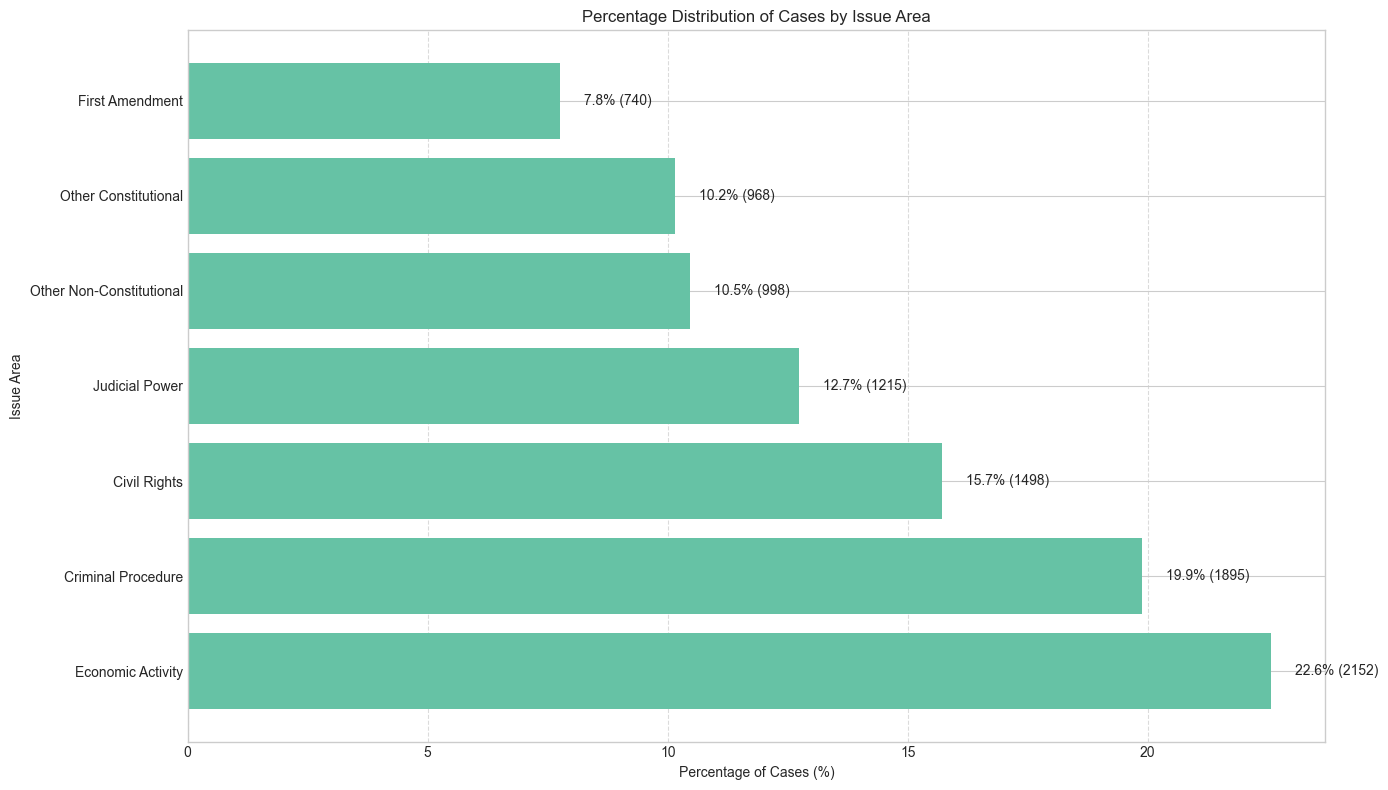

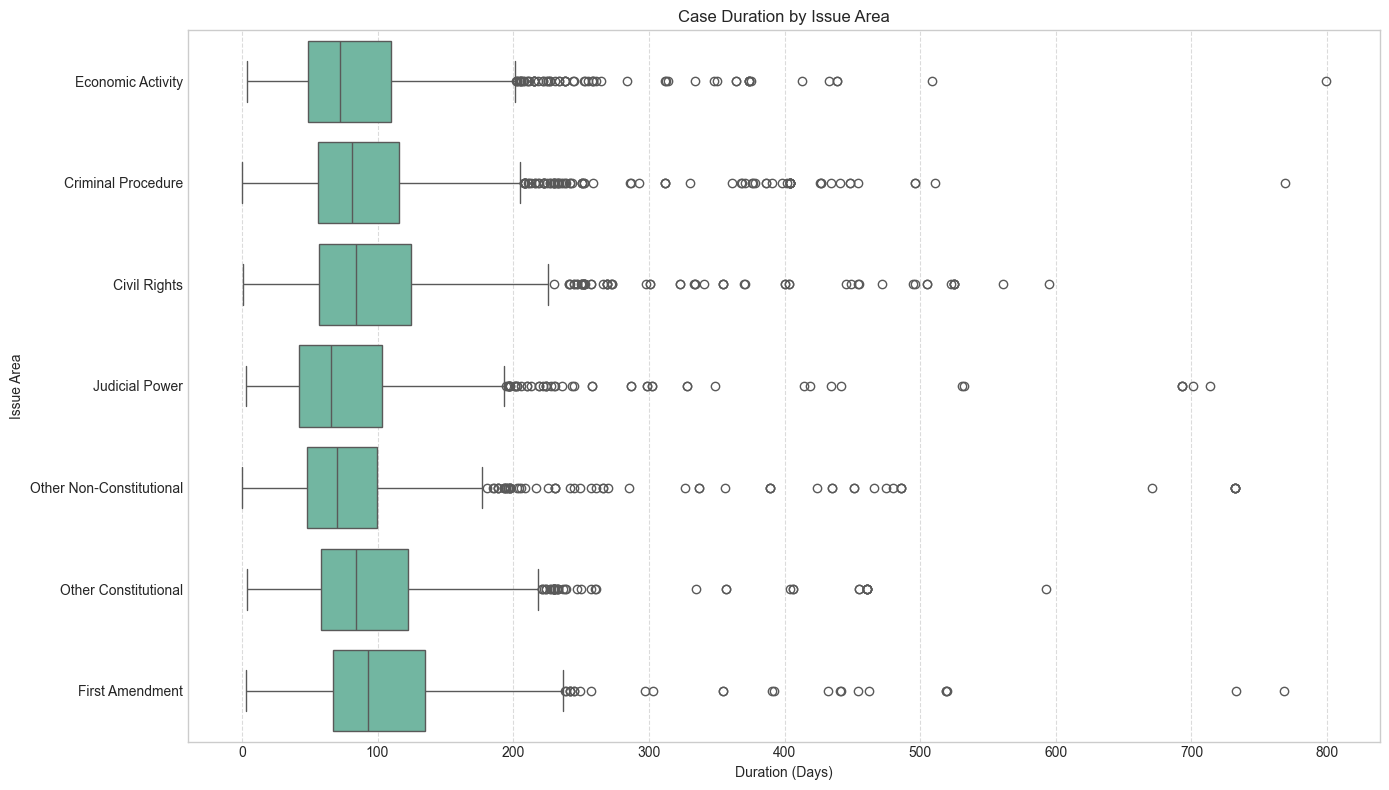

In [45]:
plt.figure(figsize=(14, 8))
issue_counts = df['issueArea_name'].value_counts()
total_cases = len(df)
issue_percentages = (issue_counts / total_cases) * 100

issue_counts = issue_counts.sort_values(ascending=False)
issue_percentages = issue_percentages.sort_values(ascending=False)

bars = plt.barh(issue_counts.index, issue_percentages)
plt.title('Percentage Distribution of Cases by Issue Area')
plt.xlabel('Percentage of Cases (%)')
plt.ylabel('Issue Area')
plt.grid(axis='x', linestyle='--', alpha=0.7)

for bar, pct, count in zip(bars, issue_percentages, issue_counts):
    plt.text(pct + 0.5, bar.get_y() + bar.get_height()/2, 
             f'{pct:.1f}% ({count})', va='center')

plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 8))
sns.boxplot(x='duration_days', y='issueArea_name', data=df, 
            order=issue_counts.index)
plt.title('Case Duration by Issue Area')
plt.xlabel('Duration (Days)')
plt.ylabel('Issue Area')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

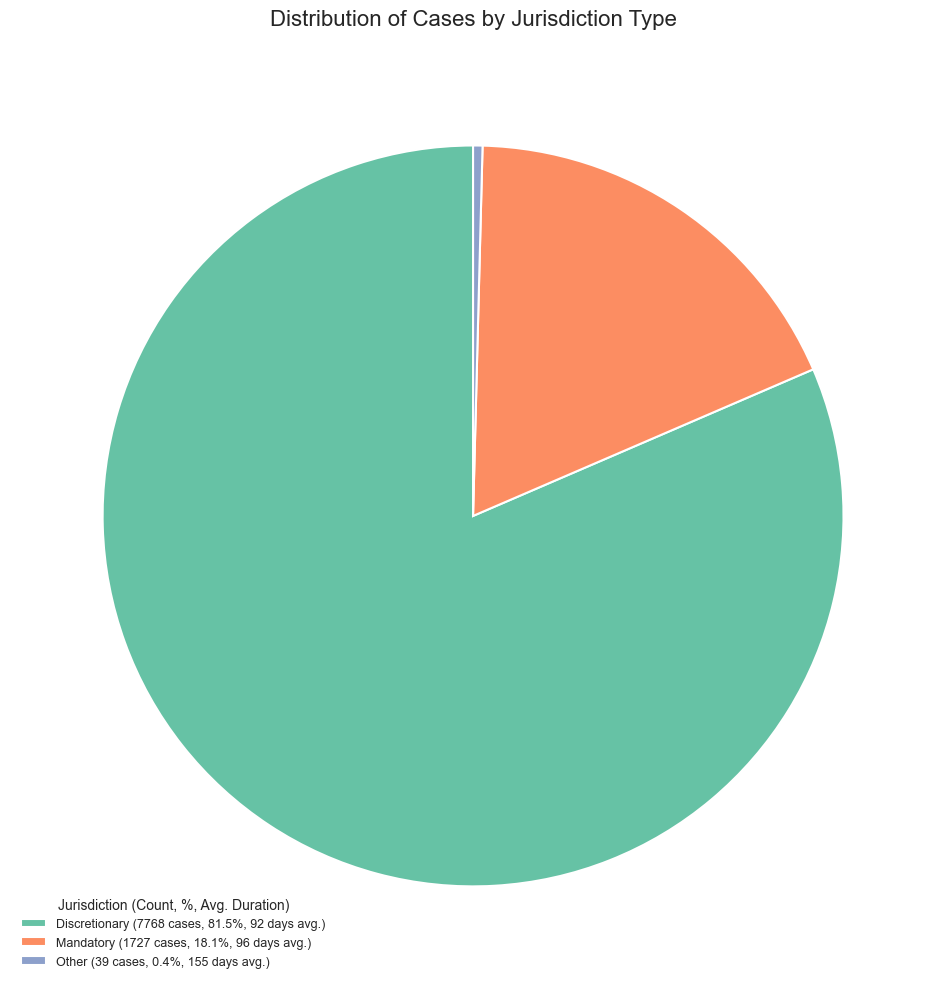

In [46]:
juris_counts = df['jurisdiction_group'].value_counts()
total_cases = len(df)
juris_percentages = (juris_counts / total_cases) * 100

plt.figure(figsize=(10, 10))
colors = sns.color_palette("Set2", len(juris_counts))
plt.pie(
    juris_counts, 
    labels=None,
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

plt.title('Distribution of Cases by Jurisdiction Type', fontsize=16, pad=20)

mean_durations = df.groupby('jurisdiction_group')['duration_days'].mean()
legend_labels = [f"{juris} ({count} cases, {pct:.1f}%, {mean_durations[juris]:.0f} days avg.)" 
                for juris, count, pct in zip(juris_counts.index, juris_counts, juris_percentages)]
plt.legend(legend_labels, title="Jurisdiction (Count, %, Avg. Duration)", 
          loc="lower left", fontsize=9)

plt.tight_layout()
plt.show()

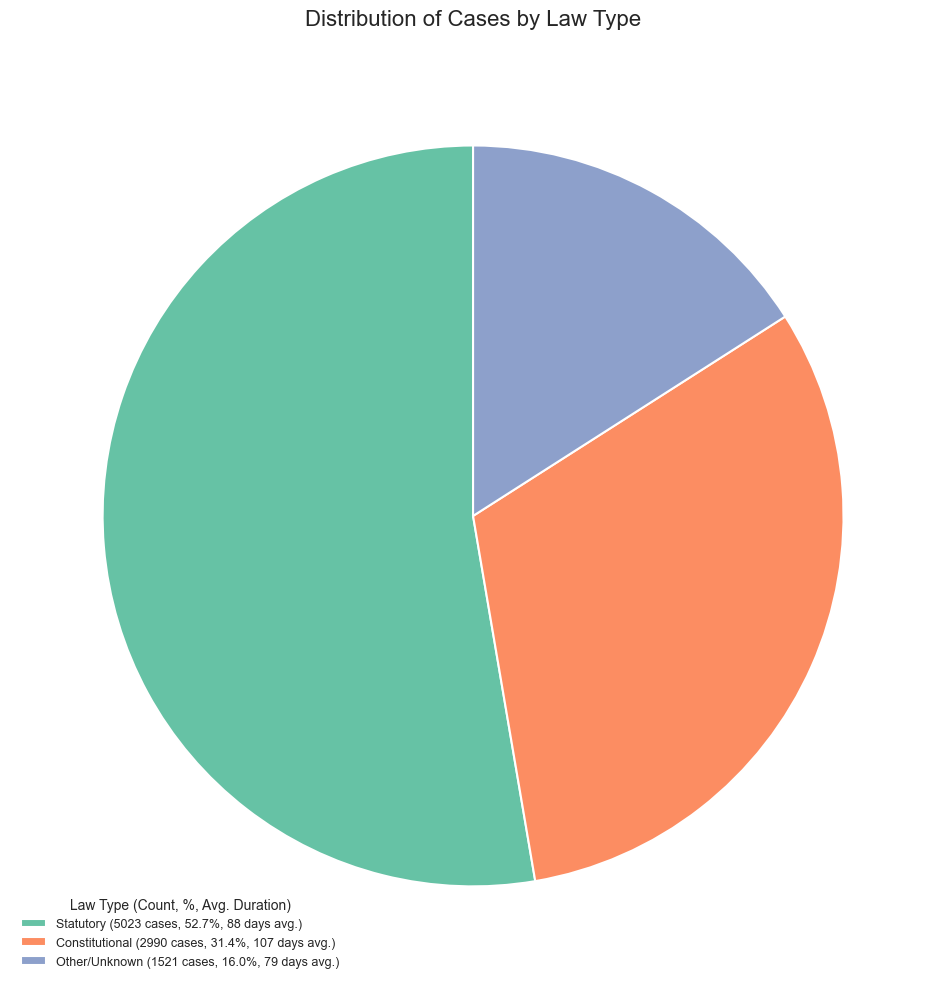

In [47]:
law_counts = df['lawType_group'].value_counts()
total_cases = len(df)
law_percentages = (law_counts / total_cases) * 100

mean_durations = df.groupby('lawType_group')['duration_days'].mean().round().astype(int)

plt.figure(figsize=(14, 10))
colors = sns.color_palette("Set2", len(law_counts))
plt.pie(
    law_counts, 
    labels=None,
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

plt.title('Distribution of Cases by Law Type', fontsize=16, pad=20)

legend_labels = [f"{law} ({count} cases, {pct:.1f}%, {mean_durations[law]} days avg.)" 
                for law, count, pct in zip(law_counts.index, law_counts, law_percentages)]
plt.legend(legend_labels, title="Law Type (Count, %, Avg. Duration)", 
          loc="lower left", fontsize=9)

plt.tight_layout()
plt.show()

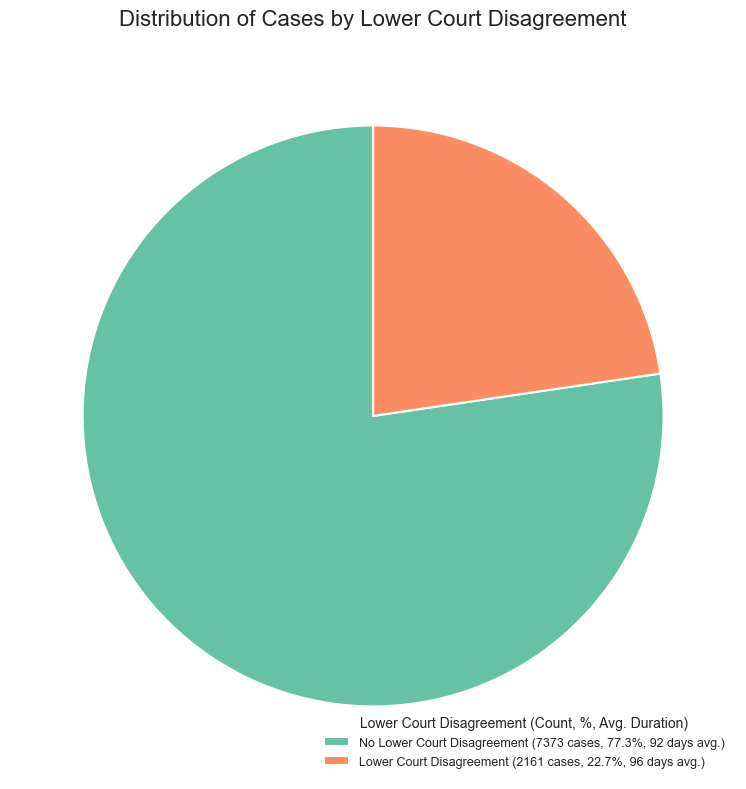

In [48]:
disagree_counts = df['lcDisagreement'].value_counts().sort_index()
total_cases = len(df)
disagree_percentages = (disagree_counts / total_cases) * 100

mean_durations = df.groupby('lcDisagreement')['duration_days'].mean().round().astype(int)

disagree_labels = {0.0: "No Lower Court Disagreement", 1.0: "Lower Court Disagreement"}

plt.figure(figsize=(10, 8))
colors = sns.color_palette("Set2", len(disagree_counts))
plt.pie(
    disagree_counts, 
    labels=None,
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

plt.title('Distribution of Cases by Lower Court Disagreement', fontsize=16, pad=20)

legend_labels = [f"{disagree_labels[val]} ({count} cases, {pct:.1f}%, {mean_durations[val]} days avg.)" 
                for val, count, pct in zip(disagree_counts.index, disagree_counts, disagree_percentages)]
plt.legend(legend_labels, title="Lower Court Disagreement (Count, %, Avg. Duration)", 
          loc="lower right", fontsize=9)

plt.tight_layout()
plt.show()

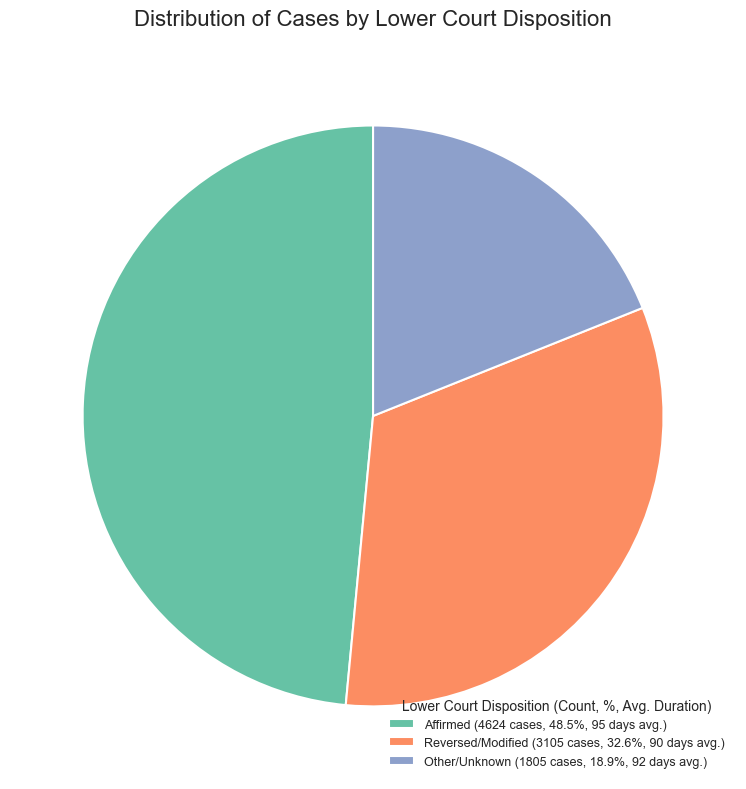

In [49]:
lc_disp_counts = df['lcDisposition_group'].value_counts()
total_cases = len(df)
lc_disp_percentages = (lc_disp_counts / total_cases) * 100

mean_durations = df.groupby('lcDisposition_group')['duration_days'].mean().round().astype(int)

plt.figure(figsize=(10, 8))
colors = sns.color_palette("Set2", len(lc_disp_counts))
plt.pie(
    lc_disp_counts, 
    labels=None,
    colors=colors,
    startangle=90,
    wedgeprops={'edgecolor': 'white', 'linewidth': 1.5}
)

plt.title('Distribution of Cases by Lower Court Disposition', fontsize=16, pad=20)

legend_labels = [f"{disp} ({count} cases, {pct:.1f}%, {mean_durations[disp]} days avg.)" 
                for disp, count, pct in zip(lc_disp_counts.index, lc_disp_counts, lc_disp_percentages)]
plt.legend(legend_labels, title="Lower Court Disposition (Count, %, Avg. Duration)", 
          loc="lower right", fontsize=9)

plt.tight_layout()
plt.show()
